***GMA – HPMA, dp_corona=78, salt = 0, pH = 7, charged = 0 and T = 70 C (44 experimental data)

1. Combine RuleFit/boosting
2. figure out others
3. K-CV randomly select fraction of training samples/ test specific samples as test data.

In [1]:
import data1 as data
import random
from common_yiwen import *
query = (data.x.core_HPMA == 1) & (data.x.corona_GMA == 1) & (data.x.dp_corona==78) & (data.x.ph==7) & (data.x.salt==0) & (data.x.charged==0) & (data.x.temp==70)
points = data.x[query]

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_indx, test_indx = Splitdata(data.x, points, rep=1, n=43).split()
test_indx

[535]

__Add RuleFit__   
First, we want to approximate parameter __Cs__ to get the empirical result comparable with Random Forest.
Observations:
* RuleFit sometimes better than RF, but not always. 
* Num of rules is hard to be optimized.
* Rules fit can be only used in individual phase diagram.

In [4]:
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier

x = data.x.filter(data.predictors, axis=1)
y = data.sphere

K = 30
cv = KFold(K, shuffle=True)

import numpy as np

Cs = [0.1, 0.5, 1, 2, 3, 4, 10]

forest = RandomForestClassifier()
forest_results = cross_validate(forest, x, y, cv=cv, scoring=['accuracy', 'neg_log_loss'], return_estimator=True, return_train_score=True)

rulefits = [RuleFit(rfmode='classify', model_type='rl', Cs=[C]) for C in Cs]
rulefit_results = []
for i in range(len(Cs)):
    rulefit_results.append(cross_validate(rulefits[i], x.values, y.replace(-1, 0), cv=cv, scoring=['accuracy'], return_estimator=True, return_train_score=True))
    rulefit_results[-1]['num_rules'] = np.array([(est.get_rules()['coef'] > 0).sum() for est in rulefit_results[-1]['estimator']])
    

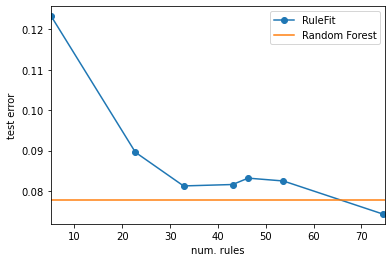

In [5]:
k = [res['num_rules'].mean() for res in rulefit_results]
err = [1-res['test_accuracy'].mean() for res in rulefit_results]
plt.plot(k, err, marker='o', label='RuleFit')
k_min = min(k) // 1
k_max = round(max(k) + 0.5)
plt.plot([k_min, k_max], [1-forest_results['test_accuracy'].mean(), 1-forest_results['test_accuracy'].mean()], label='Random Forest')
# plt.plot([k_min, k_max], [1-forest_results['train_accuracy'].mean(), 1-forest_results['train_accuracy'].mean()])
plt.xlim(k_min, k_max)
plt.xlabel('num. rules')
plt.ylabel('test error')
plt.legend()
plt.show()

## Full phase prediction


In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM
STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=8.0, max_iter=250))
gam_chain = ClassifierChain(LogisticGAM(lam=6.0, max_iter=250))
gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=6.0, max_iter=250))

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# estimators = [lr_ind, lr_chain, lr_pcc, rf_ind, rf_chain, rf_pcc]
# names = ['LR_ind', 'LR_chain', 'LR_pcc', 'RF_ind', 'RF_chain', 'RF_pcc']
# lr_chain, rf_chain remove, # check values -1, 1 test, training sizes. creating the simple size. 
# Result better/proof, remove bias (check gam, as low as possible), unbiased performance

rufit = RuleFit(rfmode='classify', model_type='rl', Cs=[3])


full_estimators = [lr_ind, lr_pcc, rf_ind, rf_pcc] # reduce some estimators
full_names = ['LR_ind', 'LR_pcc', 'RF_ind', 'RF_pcc']

indi_estimators = [lr_ind, lr_pcc, rf_ind, rf_pcc, rufit]
indi_names = ['LR_ind', 'LR_pcc', 'RF_ind', 'RF_pcc', 'Rule_fit']

In [7]:
extrapolation_full = Experiment(full_estimators, 
                    full_names,
                    Splitdata(data.x, points, rep=2, frac=0.5),
                    data.x, data.y.replace(-1.0, 0.0), # 
                    groups=None,
                    evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()

Running experiment with 2 repetitions
**


In [13]:
extrapolation_full.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.4,0.007443,0.340909,0.096424,2.905812,0.005661,3.013847,0.156788
LR_pcc,0.4,0.007443,0.340909,0.096424,2.905812,0.005661,3.013847,0.156788
RF_ind,1.0,0.000000,0.590909,0.128565,0.257969,0.006588,1.278578,0.144604
RF_pcc,1.0,0.000000,0.568182,0.096424,0.245658,0.003133,1.209719,0.114671


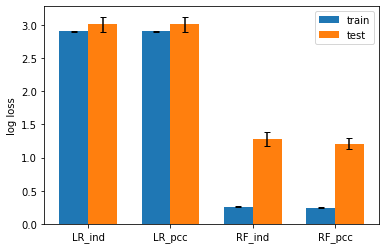

In [14]:
extrapolation_full.plot_summary('log loss')

In [9]:
extrapolation_full.summary()

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind,0.407895,0.001241,0.204545,0.032141,2.661190,0.007294,3.237043,0.203484
LR_chain,0.407895,0.001241,0.204545,0.032141,2.661190,0.007294,3.237043,0.203484
LR_pcc,0.407895,0.001241,0.204545,0.032141,2.661190,0.007294,3.237043,0.203484
RF_ind,1.000000,0.000000,0.545455,0.064282,0.243604,0.002434,1.216521,0.092217
RF_chain,1.000000,0.000000,0.568182,0.096424,0.231934,0.003633,1.287731,0.049102
RF_pcc,1.000000,0.000000,0.590909,0.064282,0.230082,0.001696,1.213341,0.022269


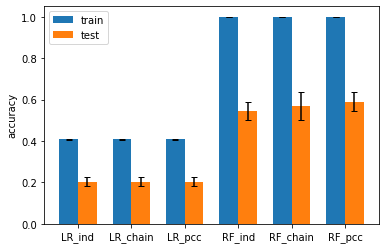

In [10]:
extrapolation_full.plot_summary('accuracy')

## Individual phase prediction

In [29]:
indi_estimators

[MultiOutputClassifier(estimator=LogisticRegressionCV(penalty='l1',
                                                      random_state=RandomState(MT19937) at 0x7F993FD47A40,
                                                      solver='saga')),
 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x7F993FD47A40)),
 RuleFit(Cs=[3], max_iter=1000, rfmode='classify')]

In [37]:
from sklearn.model_selection import KFold

inter_no_comp = {}

# This would raise some errors. Fix it by tomorrow.
for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ',y.name)
    experiment = Experiment(indi_estimators, 
                        indi_names,
                        Splitdata(data.x, points, rep=2, frac=0.5),
                        x, y.replace(-1, 0),
                        groups=data.comp_ids.array, 
                        evaluators=['accuracy', LogLikelihoodEvaluator()],
                        verbose=True)
    inter_no_comp[y.name] = experiment.run()
    print()

Target:  sphere
Running experiment with 20 repetitions


ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [ ]:
inter_no_comp['sphere'].summary()

In [ ]:
extrapolation.plot_summary('log likelihood')

In [ ]:
extrapolation.plot_summary('accuracy')